# PTB ECG Dataset Visualisation
The goal of this notebook is to visualise the PTB Diagnostic ECG Database: https://www.physionet.org/content/ptbdb/1.0.0/  
The data was downloaded from kaggle: https://www.kaggle.com/shayanfazeli/heartbeat


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import umap
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from keras.engine.saving import load_model
from keras import Model

Using TensorFlow backend.


#### Read the data

In [2]:
data_path_normal =  "../input/ptbdb_normal.csv"
data_path_abnormal = "../input/ptbdb_abnormal.csv"

In [3]:
df_1 = pd.read_csv(data_path_normal, header=None)
df_2 = pd.read_csv(data_path_abnormal, header=None)
df = pd.concat([df_1, df_2])

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1337, stratify=df[187])

Y = np.array(df_train[187].values).astype(np.int8)
X = np.array(df_train[list(range(187))].values)[..., np.newaxis]

Y_test = np.array(df_test[187].values).astype(np.int8)
X_test = np.array(df_test[list(range(187))].values)[..., np.newaxis]

### Visualize  
The following visualises only training data to avoid any influence from the test dataset.

#### Plot shapes of all classes of ECG signals.

In [4]:
# group signal levels by timepoint and class
timepoints = [[],[]]
signals = [[],[]]
for i,record in enumerate(X):
    for timepoint, value in enumerate(record):
        class_num = Y[i]
        timepoints[class_num].append(timepoint)
        signals[class_num].append(value[0])

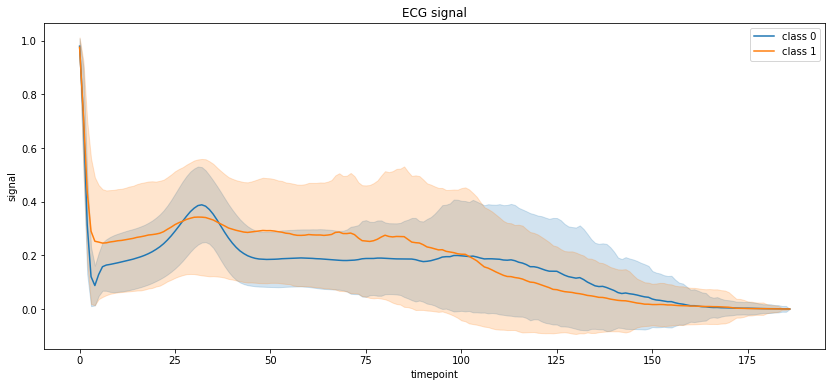

In [5]:
# plot signal shapes per class
plt.figure(figsize=(14,6))
plt.title("ECG signal")
for class_num in range(0,2):
  df_temp = pd.DataFrame({"timepoint":timepoints[class_num], "signal":signals[class_num]})
  sns.lineplot(x = "timepoint", y = "signal", data = df_temp, ci="sd", label="class " + str(class_num))
plt.show()

The plot above represents all training data. Trends can be hardly seen and the standard deviation per timepoint (shaded area) is huge.

#### Plot embeddings.

To obtain clustered embeddings we follow the same method as described in: [ECG Heartbeat Classification: A Deep TransferableRepresentation](https://arxiv.org/pdf/1805.00794.pdf).  
We reimplemented the residual CNN used in the paper and fed the output of the last convolutional layer to t-SNE and also UMAP algorithms.  
Note: In the original paper the visualisation is done on the network trained on the MIT BIH dataset to motivate transfer learning. Here we analyze the dataset in isolation, therefore we make visualisations based on the resnet trained on PTB dataset.

In [6]:
# generate balanced sample
num_per_class = 3000
total = [0,0]
X_sample = []
Y_sample = []
for i,record in enumerate(X):
        class_num = Y[i]
        if total[class_num] >= num_per_class:
            continue
        X_sample.append(record)
        Y_sample.append(class_num)
        total[class_num] += 1

X_sample = np.array(X_sample)
Y_sample = np.array(Y_sample)

In [7]:
# normalize the sample
timepoints_per_sample = 187
for sample_idx in range(X_sample.shape[0]):
    first_zero_sample = timepoints_per_sample
    while X_sample[sample_idx, first_zero_sample - 1, 0] == 0:
        first_zero_sample -= 1
    X_sample[sample_idx, 0: first_zero_sample, 0] -= np.mean(X_sample[sample_idx, 0: first_zero_sample, 0])
    X_sample[sample_idx, 0: first_zero_sample, 0] /= np.std(X_sample[sample_idx, 0: first_zero_sample, 0])

In [8]:
# get activations from the trained model
model = load_model("../saved_trained_models/paper_resnet_ptb.h5")

layer_name = 'last_layer'
intermediate_layer_model = Model(inputs=model.input,
                                  outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_sample)

#### t-SNE 

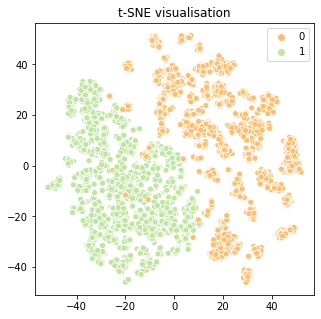

In [9]:
plt.figure(figsize=(5, 5))
X_embedded = TSNE(n_components=2, perplexity=40, learning_rate = 5, n_iter = 2000, random_state=1337)\
            .fit_transform(intermediate_output)

sns.scatterplot(x=X_embedded[:, 0], y=X_embedded[:,1], hue=Y_sample, legend = "full", palette="Spectral")
plt.title("t-SNE visualisation")
plt.show()

In the plot above we can see a clear separation between the two classes, which suggests that the residual network found representations useful in distinguishing between the two classes.

#### UMAP

In [ ]:
standard_embedding = umap.UMAP(n_neighbors= 250,min_dist = 1.,random_state=42)\
                    .fit_transform(X=intermediate_output, y=Y_sample)

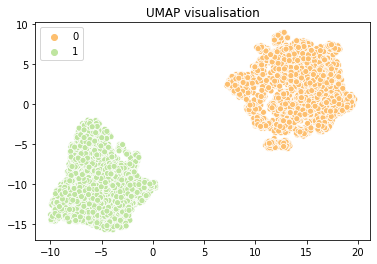

In [11]:
sns.scatterplot(standard_embedding[:,0], standard_embedding[:, 1], hue=Y_sample, legend="full", palette='Spectral')
plt.title("UMAP visualisation")
plt.show()

Again, in the plot above we can see a clear separation between the two classes, which suggests that the residual network found representations useful in distinguishing between the two classes. The UMAP method achieves an even better separation result.